In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
future_extracted_mode=0
max_tokens=10000
length = 105
dim=32

In [3]:
data_set = 'F:/NLP/hotel_reviews/tripadvisor_hotel_reviews.csv'
data = pd.read_csv(data_set,encoding='UTF-8')

In [4]:
if future_extracted_mode==1:
    embed2 = hub.KerasLayer(
        "https://tfhub.dev/google/universal-sentence-encoder/4",
        trainable=False,

    )

In [5]:
data = data.sample(frac=1, random_state=52)

"""
ratings.replace(to_replace=1, value=0,inplace=True)
ratings.replace(to_replace=2, value=0,inplace=True)
ratings.replace(to_replace=3, value=0,inplace=True)
ratings.replace(to_replace=4, value=1,inplace=True)
ratings.replace(to_replace=5, value=1,inplace=True)
"""

ratings = data['Rating']
reviews = data['Review']


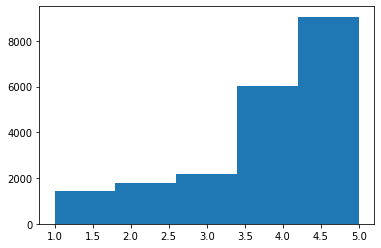

In [6]:
figure1 = plt.hist(data['Rating'],bins=5)

In [7]:
num_words = reviews.str.split().str.len()
num_words_2 = reviews.str.split().str.len().to_numpy()
num_words_median = np.average(num_words_2)
print(num_words_median,num_words_2)

104.37582353228247 [184 201  23 ... 139  37 275]


In [8]:
reviews = reviews.to_numpy()
ratings = ratings.to_numpy()
#ratings_encoded = tf.one_hot(ratings,5,on_value=1)

In [9]:
def split_chars(text):
  return " ".join(list(text))
train_chars = [split_chars(sentence) for sentence in reviews]
char_len = [len(sentence) for sentence in reviews]
char_mean = np.mean(char_len)

In [10]:
encode_labels = LabelEncoder()
encode_one_hot_labels = OneHotEncoder()
one_hot_labels =encode_one_hot_labels.fit_transform(ratings.reshape(-1,1))
labels = encode_labels.fit_transform(ratings)
encode_labels.classes_
num_classes = len(encode_labels.classes_)
num_classes

5

In [11]:
output_sq_char = int(np.percentile(char_len,95))
output_sq_char

1890

In [12]:
import string
all_char = string.ascii_lowercase +string.digits+string.punctuation
num_all_char = len(all_char)+2
vectorize = TextVectorization(
    max_tokens=max_tokens,
    standardize="lower_and_strip_punctuation",
    output_mode='int',
    output_sequence_length=length,
    pad_to_max_tokens=True
)
vectorize.adapt(reviews)
vectorize_char = TextVectorization(
    max_tokens=num_all_char,
    output_sequence_length=output_sq_char
)
vectorize_char.adapt(train_chars)

In [13]:
embed = Embedding(
    input_dim=max_tokens,
    output_dim=dim,
    embeddings_initializer='uniform',
    input_length=length
)
embed3 = Embedding(
    input_dim=num_all_char,
    output_dim=26,
    mask_zero=True,
)

In [14]:
x_train,x_valid,y_train,y_valid = train_test_split(reviews,labels, test_size=0.2,random_state=52)
class_mode = 0 #class mode means using one hot encoder
print(x_train.shape,x_valid.shape,y_train.shape,y_valid.shape)

(16392,) (4099,) (16392,) (4099,)


In [15]:
x_train_char,x_valid_char,y_train_char,y_valid_char = train_test_split(train_chars,one_hot_labels,test_size=0.2,random_state=52)

ValueError: TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]
Traceback (most recent call last):

  File "C:\Users\akghost96\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\util\structure.py", line 106, in normalize_element
    spec = type_spec_from_value(t, use_fallback=False)

  File "C:\Users\akghost96\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\util\structure.py", line 479, in type_spec_from_value
    raise TypeError("Could not build a TypeSpec for %r with type %s" %

TypeError: Could not build a TypeSpec for <16392x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16392 stored elements in Compressed Sparse Row format> with type csr_matrix


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "C:\Users\akghost96\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\base.py", line 291, in __len__
    raise TypeError("sparse matrix length is ambiguous; use getnnz()"

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]



In [17]:
if class_mode==1:
    y_train = tf.one_hot(y_train,num_classes+1,on_value=1)
    y_valid = tf.one_hot(y_valid,num_classes+1,on_value=1)

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).prefetch(tf.data.AUTOTUNE).batch(32)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid,y_valid)).prefetch(tf.data.AUTOTUNE).batch(32)

In [19]:
train_dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [20]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1,),dtype=tf.string),
    vectorize,
    embed,
    tf.keras.layers.Conv1D(256,2,activation='relu'),
    #tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 105)               0         
_________________________________________________________________
embedding (Embedding)        (None, 105, 32)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 104, 256)          16640     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [21]:
hsitory = model.fit(x_train,y_train,epochs=10,validation_data=(x_valid,y_valid))

Epoch 1/10
513/513 [==============================] - 10s 14ms/step - loss: 1.3358 - acc: 0.4438 - val_loss: 1.3391 - val_acc: 0.4494
Epoch 2/10
513/513 [==============================] - 7s 14ms/step - loss: 1.2360 - acc: 0.4531 - val_loss: 1.3772 - val_acc: 0.4189
Epoch 3/10
513/513 [==============================] - 7s 14ms/step - loss: 1.1247 - acc: 0.4935 - val_loss: 0.9863 - val_acc: 0.5484
Epoch 4/10
513/513 [==============================] - 7s 14ms/step - loss: 0.9195 - acc: 0.5740 - val_loss: 0.9671 - val_acc: 0.5416
Epoch 5/10
513/513 [==============================] - 7s 14ms/step - loss: 0.8087 - acc: 0.6359 - val_loss: 0.9207 - val_acc: 0.5921
Epoch 6/10
513/513 [==============================] - 7s 14ms/step - loss: 0.7028 - acc: 0.6989 - val_loss: 1.0235 - val_acc: 0.6004
Epoch 7/10
513/513 [==============================] - 7s 14ms/step - loss: 0.5974 - acc: 0.7532 - val_loss: 1.0647 - val_acc: 0.5850
Epoch 8/10
513/513 [==============================] - 7s 14ms/step -

In [ ]:
model.evaluate(x_valid,y_valid)

In [ ]:
test_sentence = 'nothing more horrible'
model.predict([test_sentence])